AE beginning taken from "https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac", which we will use for a "quick start" to develop our own AE.

1. Import libraries and MNIST dataset
We can import the dataset using the library torchvision. We download the training and the test datasets and we transform the image datasets into Tensor. We don’t need to normalize the images because the datasets contain colored images. After we divide the training dataset into training and validation sets.The random_split provides a random partition for these two sets. The DataLoader is used to create data loaders for the training, validation, and test sets, which are split into mini-batches. The batchsize is the number of samples used in one iteration during the training of the model.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

2. Define Convolutional Autoencoder
Here, we define the Autoencoder with Convolutional layers. It will be composed of two classes: one for the encoder and one for the decoder. The encoder will contain three convolutional layers and two fully connected layers. Some batch norm layers are added as regularizers. The decoder will have the same architecture but in inverse order.

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

3. Initialize Loss function and the optimizer
We need to define the building blocks before training the autoencoder:

torch.device to train the model with a hardware accelerator like the GPU
the Encoder and the Decoder networks, that will be moved to the device
nn.MSEloss and torch.optim.Adam

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

4. Train and evaluate model
We define a function to train the AE model. First, we pass the input images to the encoder. Later, the encoded data is passed to the decoder and then we compute the reconstruction loss with loss_fn(x_hat,x). After we clear the gradient to not accumulate other values, we perform backpropagation and at the end, we compute the gradient by calling opt.step().

In [17]:

class Epoch:
    
    def __init__(self, encoder, decoder, device, dataloader, loss_fn, optimizer,n=10):
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.dataloader = dataloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.n = n
        super().__init__()

    ### Training function
    def train_epoch(self,verbose=False):
        # Set train mode for both the encoder and the decoder
        self.encoder.train()
        self.decoder.train()
        train_loss = []
        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, _ in self.dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            # Move tensor to the proper device
            image_batch = image_batch.to(self.device)
            # Encode data
            encoded_data = self.encoder(image_batch)
            # Decode data
            decoded_data = self.decoder(encoded_data)
            # Evaluate loss
            loss = self.loss_fn(decoded_data, image_batch)
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # Print batch loss
            if verbose == True:
                print('\t partial train loss (single batch): %f' % (loss.data))
            train_loss.append(loss.detach().cpu().numpy())

        return np.mean(train_loss)

    def test_epoch(self):
        # Set evaluation mode for encoder and decoder
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out = []
            conc_label = []
            for image_batch, _ in self.dataloader:
                # Move tensor to the proper device
                image_batch = image_batch.to(self.device)
                # Encode data
                encoded_data = self.encoder(image_batch)
                # Decode data
                decoded_data = self.decoder(encoded_data)
                # Append the network output and the original image to the lists
                conc_out.append(decoded_data.cpu())
                conc_label.append(image_batch.cpu())
            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            # Evaluate global loss
            val_loss = self.loss_fn(conc_out, conc_label)
        return val_loss.data
    
    def train(self,num_epochs=2,verbose=False):
        self.diz_loss = {'train_loss':[],'val_loss':[]}
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(verbose=verbose)
            val_loss = self.test_epoch()
            print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
            self.diz_loss['train_loss'].append(train_loss)
            self.diz_loss['val_loss'].append(val_loss)
            self.plot_ae_outputs()
        
    
    def plot_ae_outputs(self):
        plt.figure(figsize=(16,4.5))
        targets = test_dataset.targets.numpy()
        t_idx = {i:np.where(targets==i)[0][0] for i in range(self.n)}
        for i in range(self.n):
            ax = plt.subplot(2,self.n,i+1)
            img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
            self.encoder.eval()
            self.decoder.eval()
            with torch.no_grad():
                rec_img  = self.decoder(self.encoder(img))
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == self.n//2:
                ax.set_title('Original images')
            ax = plt.subplot(2, self.n, i + 1 + self.n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == self.n//2:
                ax.set_title('Reconstructed images')
        plt.show()  

    def plot_losses(self):
        # Plot losses
        plt.figure(figsize=(10,8))
        plt.semilogy(self.diz_loss['train_loss'], label='Train')
        plt.semilogy(self.diz_loss['val_loss'], label='Valid')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        #plt.grid()
        plt.legend()
        #plt.title('loss')
        plt.show()

Once the training function is created, we define a function to evaluate the performance of the model. As before, we pass the image to the encoder. The encoded image is passed to the decoder. Then, we store all the image batches and the reconstruction into two different lists, that will be used to calculate the test loss.


 EPOCH 1/2 	 train loss 0.028594646602869034 	 val loss 0.0283073578029871


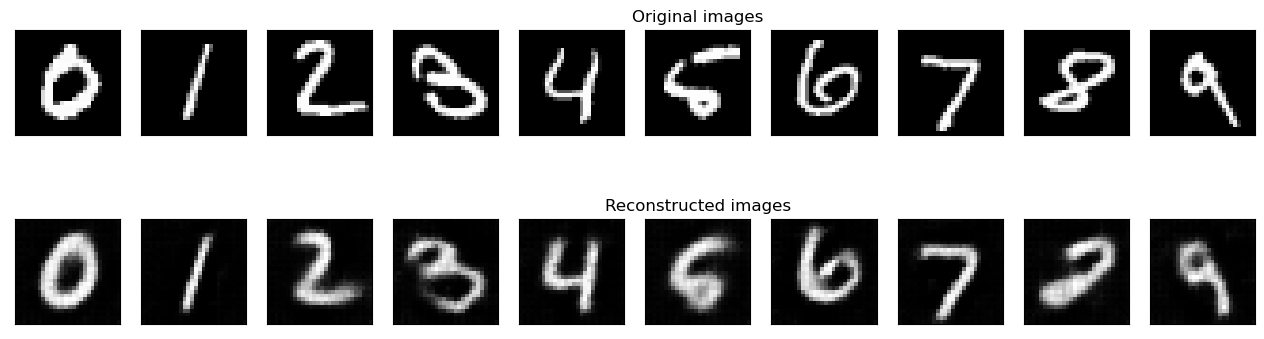


 EPOCH 2/2 	 train loss 0.028183257207274437 	 val loss 0.02795817144215107


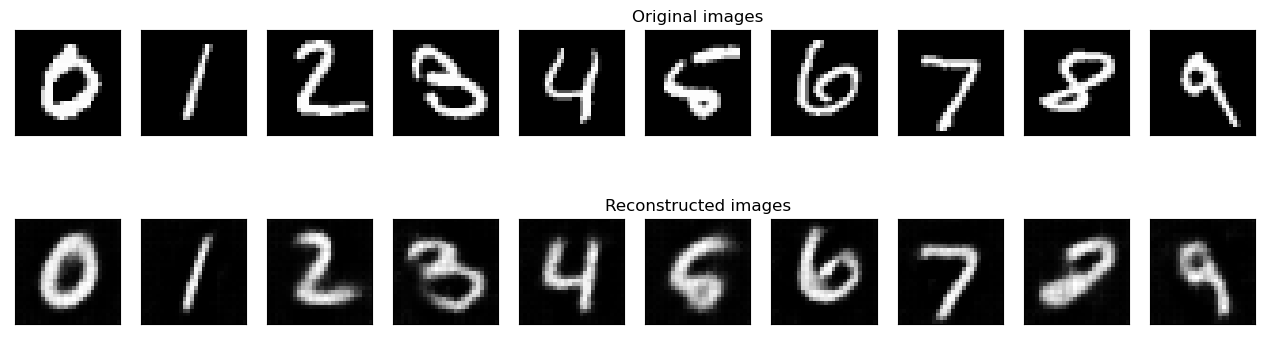

0.02795817144215107

In [18]:
model2 = Epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
model2.train(verbose=False)
model2.test_epoch().item()

We also would like to see the reconstructed images during each epoch of the training. The goal is to understand how the autoencoder is learning from the input images.

Let’s break the test code into little pieces:

test_dataset[i][0].unsqueeze(0) is used to extract the ith image from the test dataset and then it will be increased by 1 dimension on the 0 axis. This step is needed to pass the image to the autoencoder.
decoder(encoder(img))is used to obtain the reconstructed image
plt.imshow(img.cpu().squeeze().numpy())is used to plot the original image. squeeze()removes the dimension added before and is essential to visualize the image. numpy() transforms a tensor into a n-dimensional array, which is the only type of object accepted by the function plt.imshow. numpy() returns a copy of the tensor object into CPU memory.
Now we can finally begin to train the model on the training set and evaluate it on the validation set.

It’s possible to notice that the autoencoder is able to reconstruct well the images after 30 epochs, even if there are some imperfections. But since this model is really simple, it performed very well. Now the model is trained and we want to do a final evaluation of the test set:

We can also observe how the reconstruction losses decrease over the epochs:

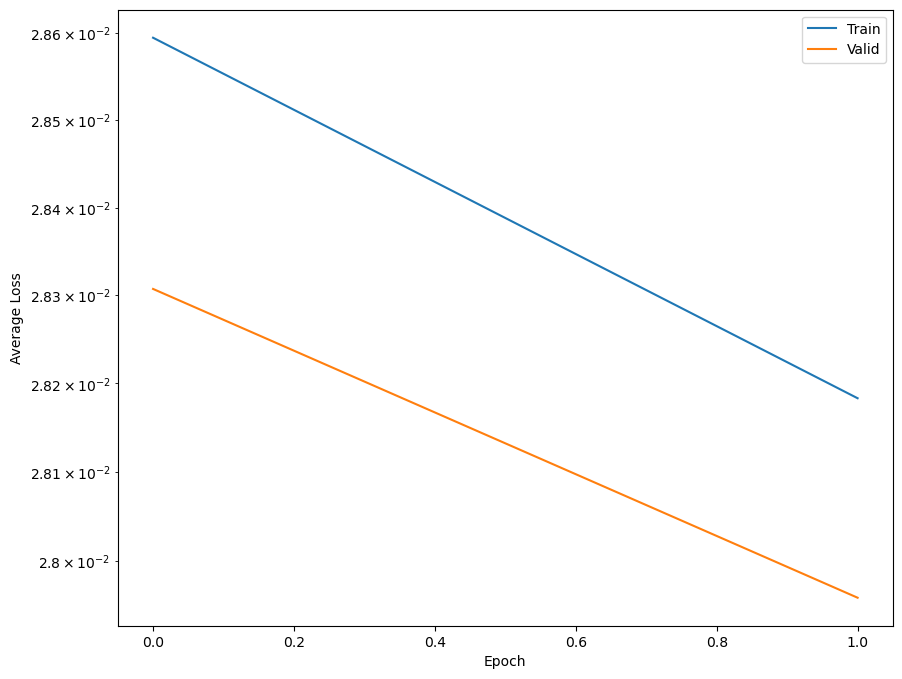

In [19]:
model2.plot_losses()

5. Generate new samples from the random latent code
To generate new images from the latent code, we sample randomly from a normal distribution with the mean and standard deviation of the encoded data. These samples will be passed to the decoder, which will create the reconstructed images.

tensor([-0.1568,  0.2217,  0.1772,  0.0989])
tensor([0.5433, 0.7083, 0.6536, 0.6196])


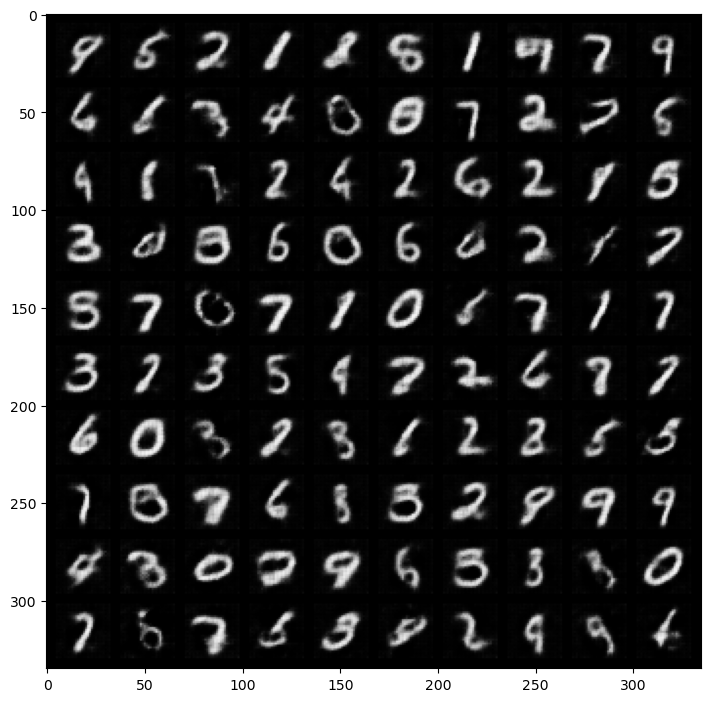

In [20]:

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

model2.encoder.eval()
model2.decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader)) #Changed in recent update to next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

It should notice that this procedure allows the sampling to be in the same region as the latent code but at the same time there are digits that make no sense. This aspect is explained by the fact that the latent space of the autoencoder is extremely irregular: close points in the latent space can produce very different and meaningless patterns over visible units. For this reason, the autoencoder doesn’t perform well for generative purposes.

6. Visualize the latent space with t-SNE
After we can observe dynamic visualization to see the latent space learned by the autoencoder. First, we create the encoded samples using the test set.

In [13]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    model2.encoder.eval()
    with torch.no_grad():
        encoded_img  = model2.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:04<00:00, 2105.61it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-1.622627,1.676711,0.176233,0.331652,7
1,0.726621,0.997533,1.191827,0.464366,2
2,0.283539,1.246110,-0.730498,1.114477,1
3,-0.031860,-0.875449,0.533652,-0.141235,0
4,-0.826256,0.059582,-0.844441,-1.295472,4
...,...,...,...,...,...
9995,-0.263844,0.675249,0.991311,0.694670,2
9996,0.629812,0.080767,1.060989,0.119200,3
9997,-0.642759,0.375326,-0.473352,0.234284,4
9998,-0.207211,-0.454076,-0.271622,0.837885,5


Let’s plot the latent space representation using plotly express library:

In [14]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

From this plot, we see that similar digits are clustered together. For example “4” overlap with “9” and “5”.

In order to have an easier representation to read, we can apply a dimensionality reduction, called t-SNE, to visualize the latent code in a 2d space. We’ll fix the number of components equal to 2 for this reason.



In [15]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

c:\Users\Mikkel Groengaard\anaconda3\envs\chatbot\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Mikkel Groengaard\anaconda3\envs\chatbot\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



You can see that it distinguishes clearly one digit from the other. There are some exceptions with points that fall in other categories, but t-SNE still remains an improvement compared to the previous representation.